### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import missingno as msno
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

### Reading data and Exploration

In [2]:
data_set = pd.read_csv('sales_dataset_en_headers.csv', encoding='utf-8')
print("Dataset Info:")
print(data_set.info())
print("\nFirst five rows:")
print(data_set.head())
print("\nMissing Values:")
print(data_set.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           1007 non-null   int64  
 1   order_date         1007 non-null   object 
 2   order_count        1007 non-null   int64  
 3   shiping_method     1007 non-null   object 
 4   unit_price         1007 non-null   float64
 5   customer_name      1007 non-null   object 
 6   customer_division  1007 non-null   object 
 7   product_category   1007 non-null   object 
 8   sale               999 non-null    object 
 9   profit             999 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 78.8+ KB
None

First five rows:
   order_id  order_date  order_count shiping_method  unit_price  \
0         3  10/13/2010            6     هوایی عادی       38.94   
1         6   2/20/2012            2     هوایی عادی        2.08   
2        32   7/

###  Data preprocessing

#### Convert Excel serial date to datetime

In [3]:
data_set['order_date'] = pd.to_datetime(data_set['order_date'], dayfirst=True)

#### extract numbers in sale and profit column
a function that returns a float from a string

In [4]:
def extract_number_from_string(text):
    """
    a function that returns a float from a string
    """
    try:
        string_number = ''.join(char for char in str(text) if char.isdigit() or char == '.')
        return float(string_number)
    except (ValueError, TypeError):
        return None

create new columns for numerical sale and profit

In [5]:
data_set['sale $'] = data_set['sale'].apply(extract_number_from_string)
data_set['profit $'] = data_set['profit'].apply(extract_number_from_string)
data_set.head()

,order_id,order_date,order_count,shiping_method,unit_price,customer_name,customer_division,product_category,sale,profit,sale $,profit $
0,3,2010-10-13,6,هوایی عادی,38.94,Muhammed MacIntyre,کسب‌وکار کوچک,لوازم اداری,$261.54,$(213.25),261.54,213.25
1,6,2012-02-20,2,هوایی عادی,2.08,Ruben Dartt,شرکتی,لوازم اداری,$6.93,$(4.64),6.93,4.64
2,32,2011-07-15,26,هوایی عادی,107.53,Liz Pelletier,شرکتی,مبلمان,"$2,808.08","$1,054.82",2808.08,1054.82
3,32,2011-07-15,24,کامیون تحویل,70.89,Liz Pelletier,شرکتی,مبلمان,"$1,761.40","$(1,748.56)",1761.40,1748.56
4,32,2011-07-15,23,هوایی عادی,7.99,Liz Pelletier,شرکتی,تکنولوژی,$160.23,$(85.13),160.23,85.13


#### Handle missing values in sales and profit

In [6]:
data_set['sale/(order_count*unit_price)'] = data_set['sale $'] / (data_set['order_count'] * data_set['unit_price'])
s_by_oc_up_median = data_set['sale/(order_count*unit_price)'].median()
data_set['sale $'] = data_set.apply(lambda row: row['order_count'] * row['unit_price'] * s_by_oc_up_median if pd.isna(row['sale $']) else row['sale $'], axis=1)

data_set['profit_margin'] = data_set['profit $'] / data_set['sale $']
median_ratios = data_set.groupby('product_category')['profit_margin'].median()

data_set['median_profit_ratio'] = data_set['product_category'].map(median_ratios)
data_set['profit $'] = data_set.apply(lambda row: row['sale $'] * row['median_profit_ratio'] if pd.isna(row['profit $']) else row['profit $'], axis=1)
data_set['profit_margin'] = (data_set['profit $'] / data_set['sale $'] * 100).round(2)

#### checking the missing values a barplot

<Axes: >

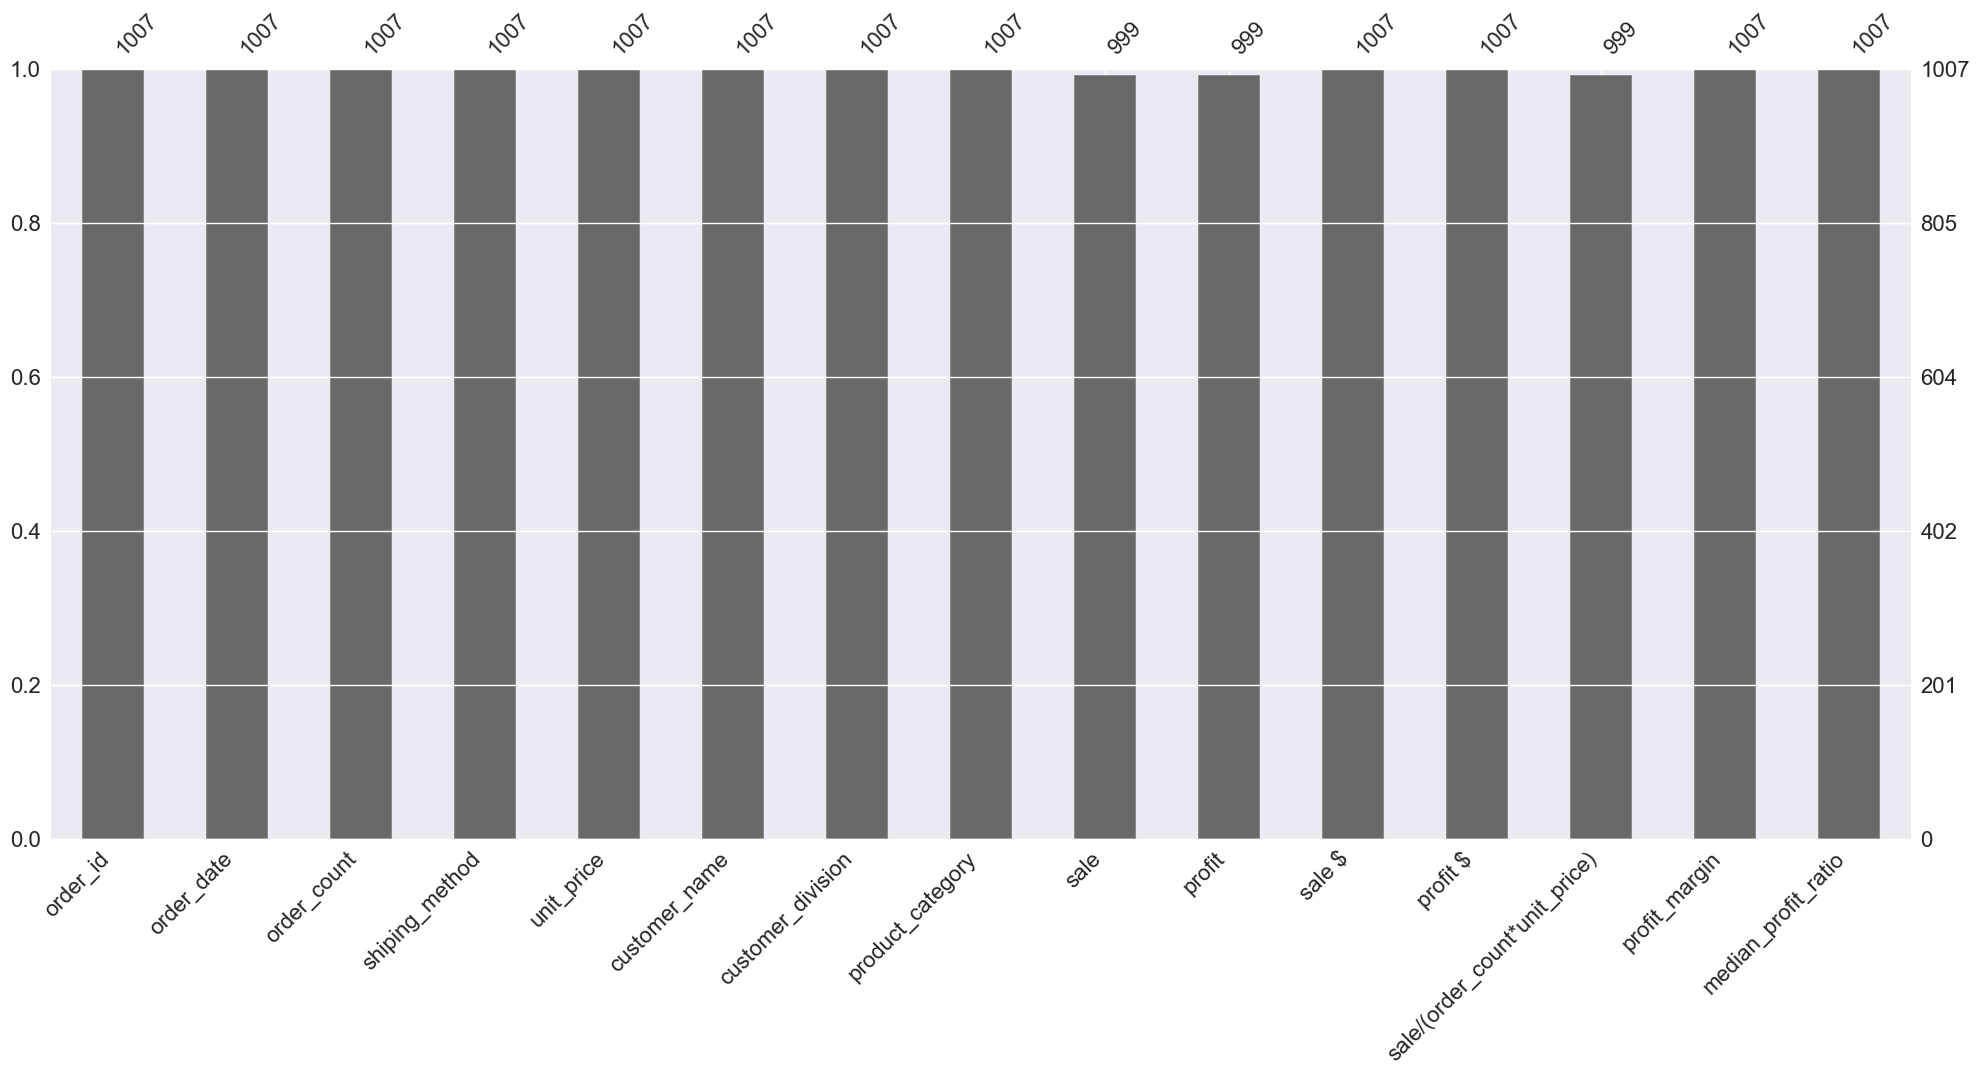

In [7]:
msno.bar(data_set)

According to the missing values barplot all missing values of sale and profit handled in (sale dollar) and (profit dollar) columns.In the code below we are going to get rid of unnecessary columns.

<Axes: >

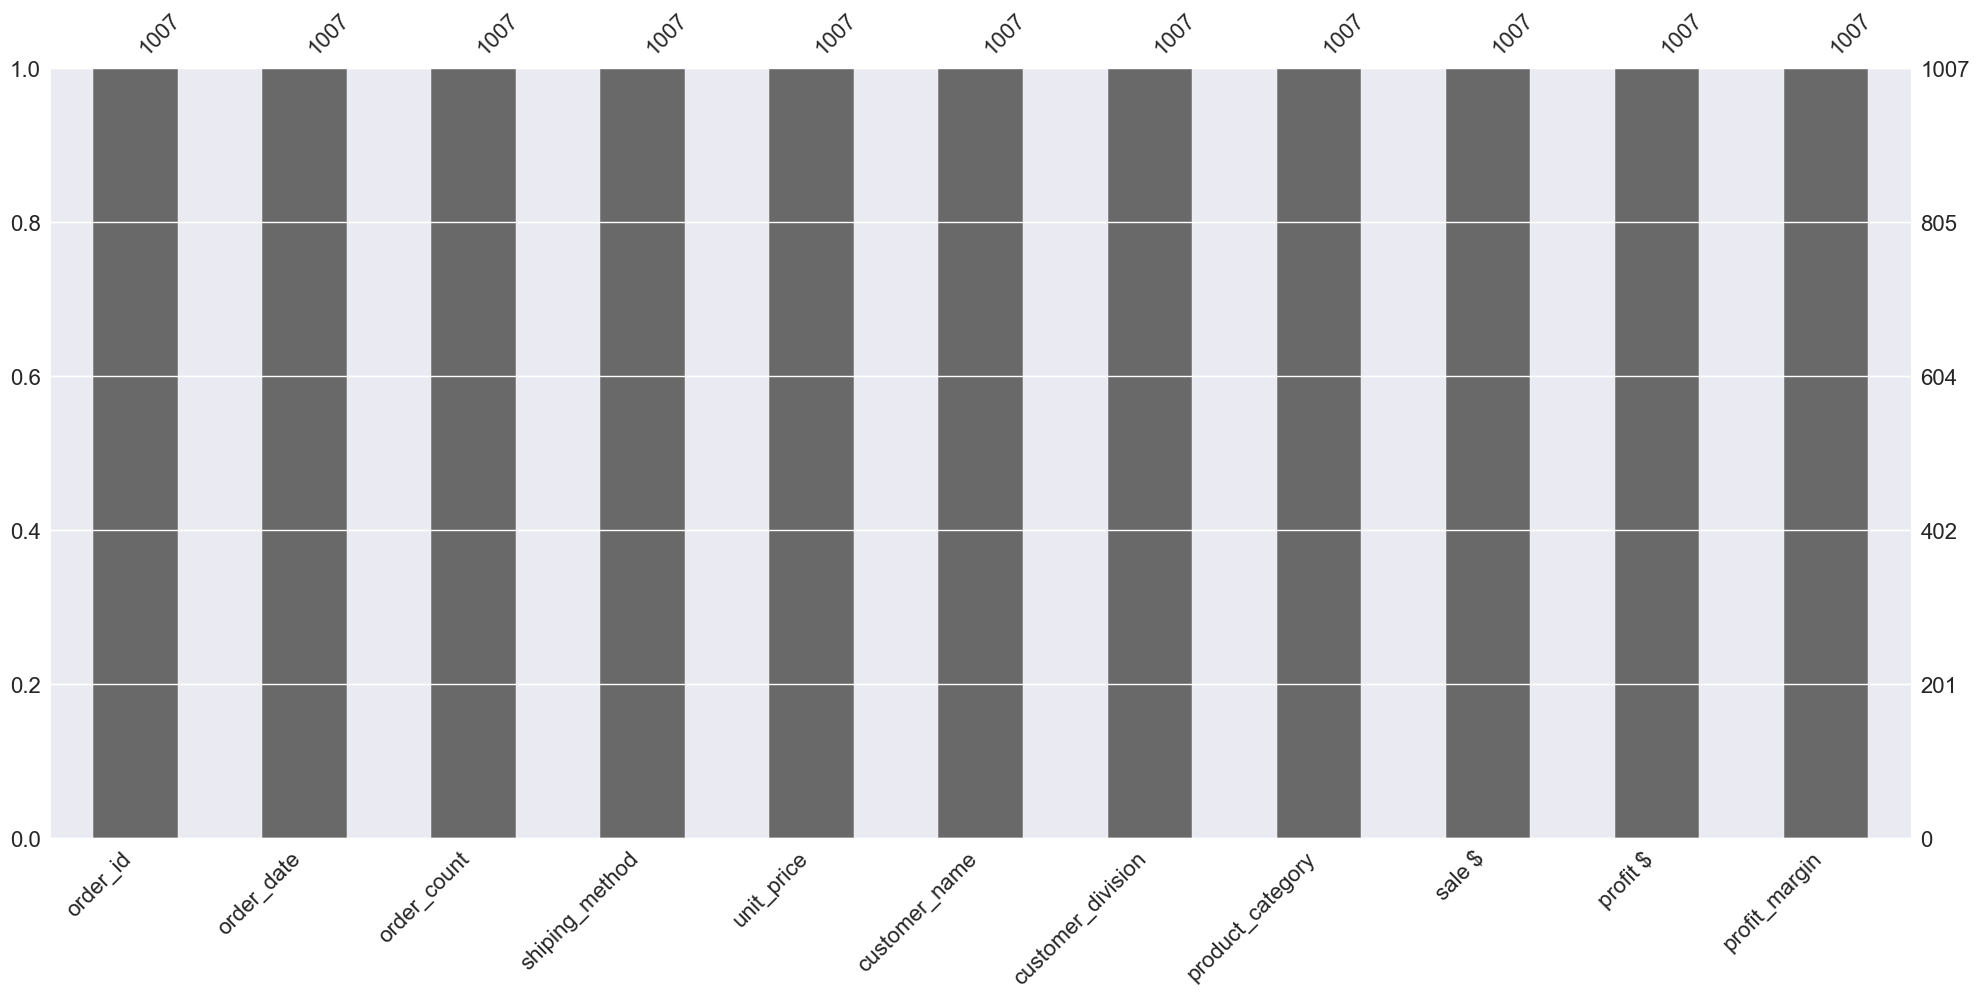

In [8]:
data_set = data_set.drop(columns=['sale', 'profit', 'sale/(order_count*unit_price)', 'median_profit_ratio'])
msno.bar(data_set)

### Exploratory Data Analysis

#### Statistics summary

In [9]:
data_set.describe()

,order_id,order_date,order_count,unit_price,sale $,profit $,profit_margin
count,1007.000000,1007,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000
mean,3478.923535,2010-12-24 04:24:32.889771776,24.832175,91.255045,1868.130972,442.666448,34.730765
min,3.000000,2008-07-15 00:00:00,1.000000,1.260000,2.240000,0.030000,0.050000
25%,1665.500000,2010-01-05 00:00:00,12.000000,6.480000,132.950000,29.695000,11.905000
50%,3456.000000,2010-12-24 00:00:00,25.000000,20.970000,416.400000,100.050000,24.420000
75%,5350.000000,2012-01-04 00:00:00,38.000000,95.950000,1715.239440,354.820000,42.145000
max,7239.000000,2012-12-28 00:00:00,50.000000,6783.020000,45923.760000,11535.280000,831.900000
std,2119.704215,NaN,14.367466,294.993321,3838.064873,1064.048487,50.966466


#### Distribution plots

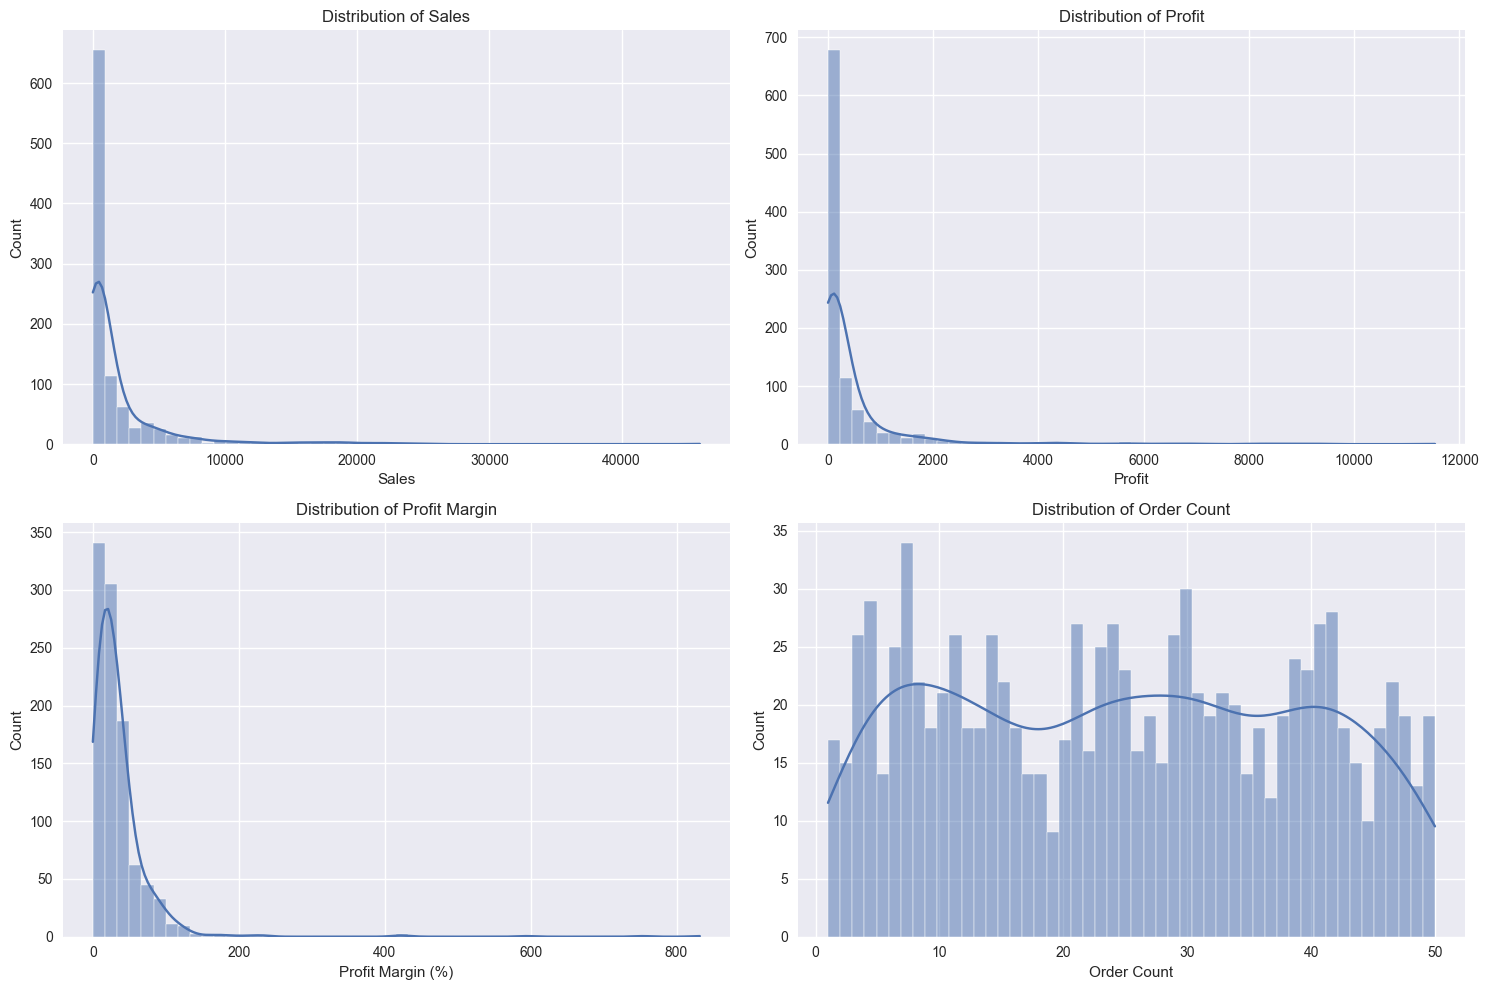

In [10]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(data_set['sale $'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')

plt.subplot(2, 2, 2)
sns.histplot(data_set['profit $'], bins=50, kde=True)
plt.title('Distribution of Profit')
plt.xlabel('Profit')

plt.subplot(2, 2, 3)
sns.histplot(data_set['profit_margin'], bins=50, kde=True)
plt.title('Distribution of Profit Margin')
plt.xlabel('Profit Margin (%)')

plt.subplot(2, 2, 4)
sns.histplot(data_set['order_count'], bins=50, kde=True)
plt.title('Distribution of Order Count')
plt.xlabel('Order Count')

plt.tight_layout()
plt.show()

#### Categorical variable analysis

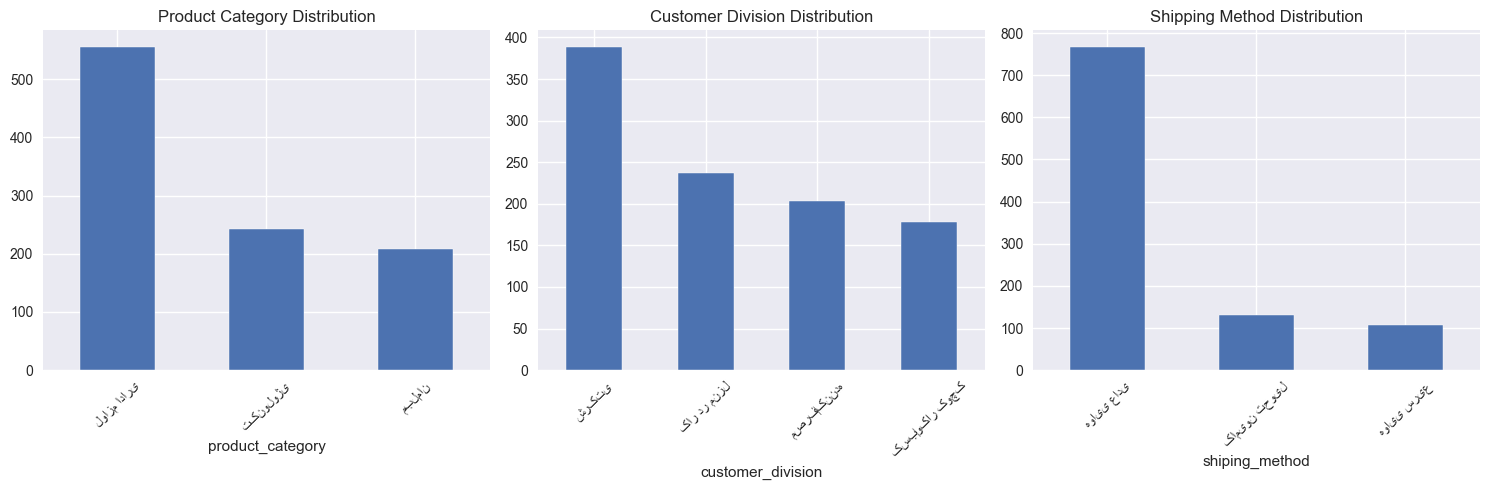

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
data_set['product_category'].value_counts().plot(kind='bar')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
data_set['customer_division'].value_counts().plot(kind='bar')
plt.title('Customer Division Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
data_set['shiping_method'].value_counts().plot(kind='bar')
plt.title('Shipping Method Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Correlation matrix

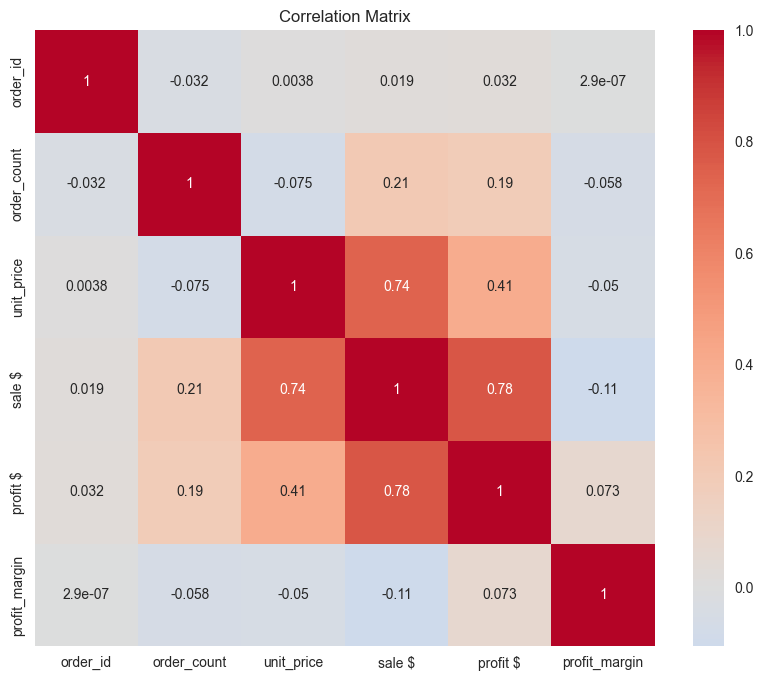

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_set.select_dtypes(include=['int64', 'float64', 'bool']).corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### Statistical Tests

#### Normality test (Shapiro-Wilk)

In [13]:
print("Sales:", stats.shapiro(data_set['sale $'].dropna())[:2])
print("Profit:", stats.shapiro(data_set['profit $'].dropna())[:2])

Sales: (np.float64(0.5017111153959446), np.float64(1.9482182331204537e-46))
Profit: (np.float64(0.41570481235867796), np.float64(6.331051555651582e-49))


#### ANOVA for profit across customer division

In [15]:
divisions = data_set['customer_division'].unique()
profit_by_division = [data_set[data_set['customer_division'] == div]['profit $'].dropna() for div in divisions]
anova_result = stats.f_oneway(*profit_by_division)
print("\nANOVA for Profit across Customer divisions:")
print(f"F-statistic: {anova_result.statistic:.2f}, p-value: {anova_result.pvalue:.4f}")


ANOVA for Profit across Customer divisions:
F-statistic: 0.85, p-value: 0.4657


#### ANOVA for sales across product categories


In [16]:
categories = data_set['product_category'].unique()
sales_by_category = [data_set[data_set['product_category'] == cat]['sale $'].dropna() for cat in categories]
anova_result = stats.f_oneway(*sales_by_category)
print("\nANOVA for Sales across Product Categories:")
print(f"F-statistic: {anova_result.statistic:.2f}, p-value: {anova_result.pvalue:.4f}")


ANOVA for Sales across Product Categories:
F-statistic: 46.15, p-value: 0.0000


### Advanced Analysis

#### Time series analysis

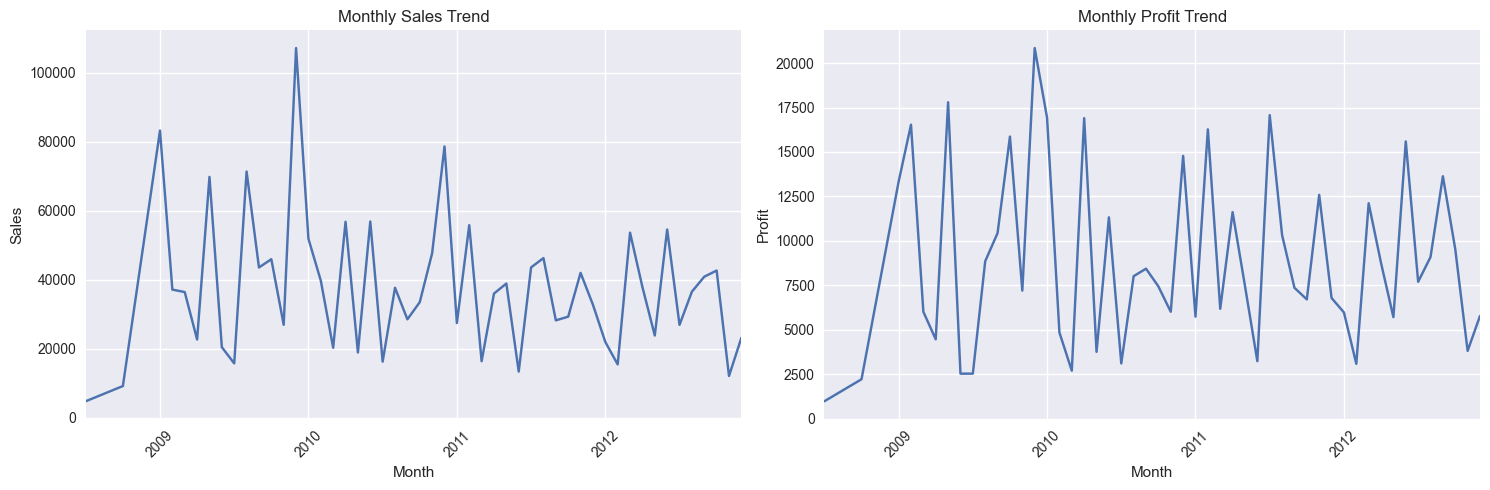

In [18]:
monthly_sales = data_set.groupby(data_set['order_date'].dt.to_period('M'))['sale $'].sum()
monthly_profit = data_set.groupby(data_set['order_date'].dt.to_period('M'))['profit $'].sum()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Sales')

plt.subplot(1, 2, 2)
monthly_profit.plot()
plt.title('Monthly Profit Trend')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Profit')

plt.tight_layout()
plt.show()

#### Top 10 customers by sales

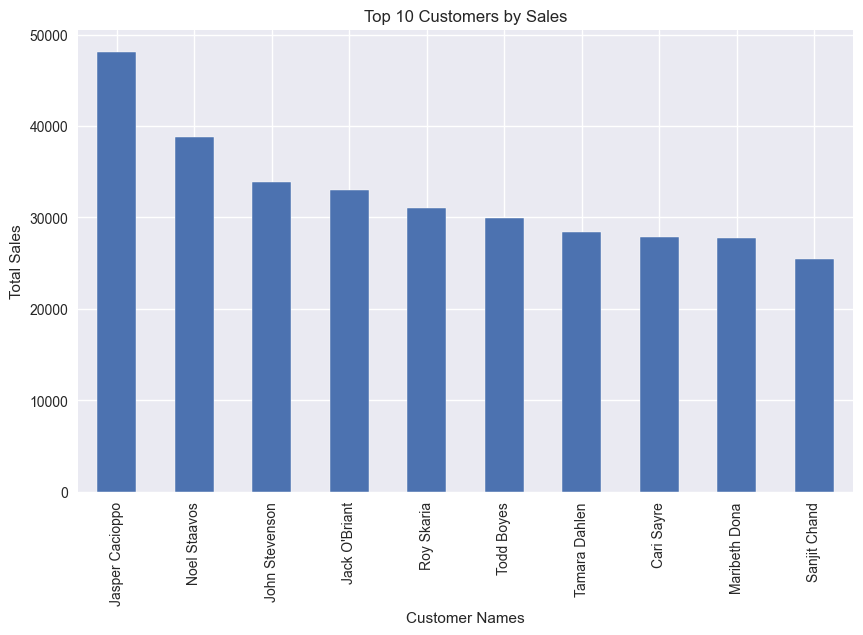

In [21]:
top_customers = data_set.groupby('customer_name')['sale $'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_customers.plot(kind='bar')
plt.title('Top 10 Customers by Sales')
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.xlabel('Customer Names')
plt.show()

#### Profitability by category and segment

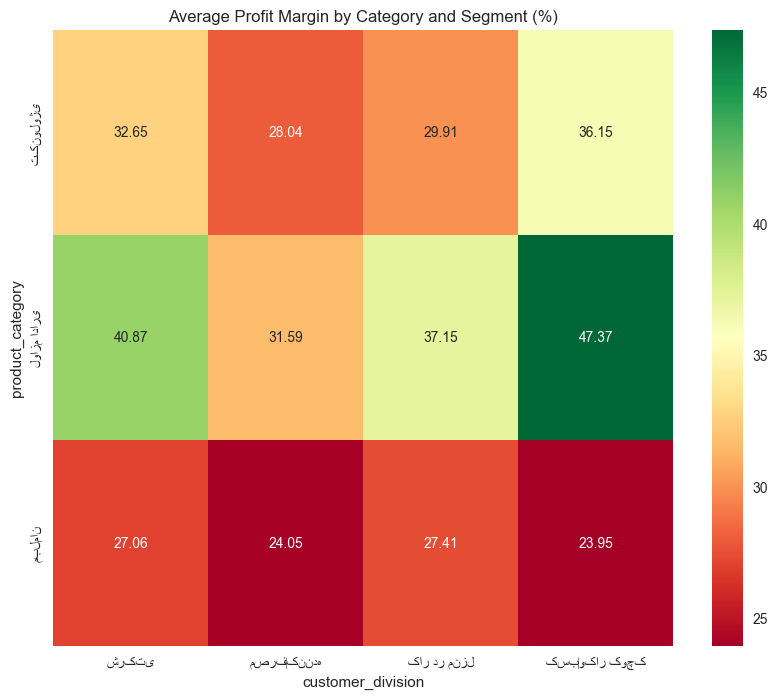

In [22]:
pivot_profit = data_set.pivot_table(values='profit_margin', 
                              index='product_category', 
                              columns='customer_division', 
                              aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_profit, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Average Profit Margin by Category and Segment (%)')
plt.show()